## 2,000 Cleaned Medical Articles: Masked Language Modeling


Dataset Source: https://www.kaggle.com/datasets/trikialaaa/2k-clean-medical-articles-medicalnewstoday

#### Install Necessary & Missing Libraries

In [1]:
%pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 962.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

#### Import Necessary & Missing Libraries

In [2]:
import os, sys, random, math

import pandas as pd

import matplotlib.pyplot as plt

import torch

import datasets
from datasets import ClassLabel, Dataset, DatasetDict

import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer, set_seed

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Display Library Versions

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.16
        Pandas: 1.4.4
      Datasets: 2.10.1
  Transformers: 4.27.1


#### Login For Access to HuggingFace

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Mount Google Drive to Notebook

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Dataset

In [6]:
parent_dir = "/content/drive/MyDrive/Colab Notebooks/US Econ Articles"

data_file = os.path.join(parent_dir, "US-Economic-News.csv")

data = pd.read_csv(data_file, encoding_errors="ignore", usecols=["text"])

data

,text
0,NEW YORK -- Yields on most certificates of dep...
1,The Wall Street Journal Online</br></br>The Mo...
2,WASHINGTON -- In an effort to achieve banking ...
3,The statistics on the enormous costs of employ...
4,NEW YORK -- Indecision marked the dollar's ton...
...,...
7995,Secretary of Commerce Charles W. Sawyer said y...
7996,"U.S. stocks inched up last week, overcoming co..."
7997,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,The White House's push to contract out many fe...


#### Visual: Histogram of Input Lengths

The maximum length of this dataset is approximately 863 words.


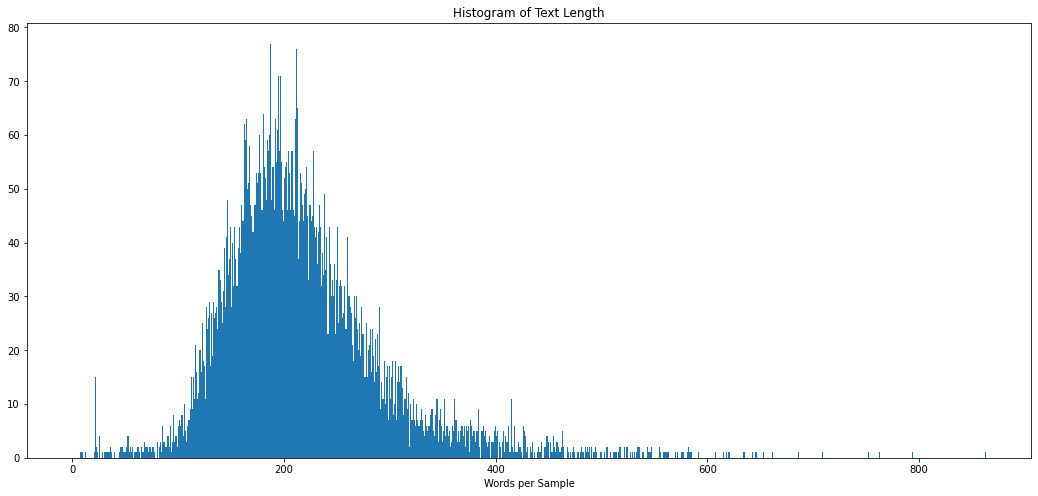

In [7]:
data['input_len'] = data['text'].str.split().str.len()

max_len = max(data['input_len'])

print(f"The maximum length of this dataset is approximately {max_len} words.")

n = max_len
data.hist("input_len", grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Remove Unnecessary Features

In [8]:
data = data.drop(columns=["input_len"])
data

,text
0,NEW YORK -- Yields on most certificates of dep...
1,The Wall Street Journal Online</br></br>The Mo...
2,WASHINGTON -- In an effort to achieve banking ...
3,The statistics on the enormous costs of employ...
4,NEW YORK -- Indecision marked the dollar's ton...
...,...
7995,Secretary of Commerce Charles W. Sawyer said y...
7996,"U.S. stocks inched up last week, overcoming co..."
7997,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,The White House's push to contract out many fe...


#### Convert DataFrame to Dataset

In [9]:
dataset = Dataset.from_pandas(data)

dataset

Dataset({
    features: ['text'],
    num_rows: 8000
})

#### Split Dataset into Training & Evaluation Datasets

In [10]:
train_testvalid = dataset.train_test_split(test_size=0.20)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'eval' : train_testvalid['test']
})

print('Training data shape:', ds['train'].shape)
print('Evaluation data shape:', ds['eval'].shape)
print(ds['train'].features)

Training data shape: (6400, 1)
Evaluation data shape: (1600, 1)
{'text': Value(dtype='string', id=None)}


#### Basic Values/Constants

In [11]:
BLOCK_SIZE = 128
MODEL_CKPT = "bert-base-uncased"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Masked_Language_Model-US_Economic_News_Articles"
set_seed = 42

BATCH_SIZE = 1000 
NUM_OF_EPOCHS = 3

WEIGHT_DECAY = 0.01
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
LEARNING_RATE = 2e-5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Tokenize Entire Dataset

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                          use_fast=True)

def tokenizer_function(samples):
    return tokenizer(samples["text"])

#### Apply Tokenizer Function to Entire Dataset

In [13]:
tokenized_ds = ds.map(tokenizer_function, 
                      batched=True,
                      num_proc=4,
                      remove_columns=["text"])

print(tokenized_ds["train"])
print(tokenized_ds["eval"])

Map (num_proc=4):   0%|          | 0/6400 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (644 > 512). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/1600 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6400
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1600
})


#### Preprocess Tokenized Dataset

In [14]:
def group_texts(samples):
    concatenated_samples = {k: sum(samples[k], []) for k in samples.keys()}
    total_length = len(concatenated_samples[list(samples.keys())[0]])
    
    if total_length >= BLOCK_SIZE:
        total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE
    
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_samples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

#### Apply Preprocessing Function to Dataset

In [15]:
mlm_ds = tokenized_ds.map(
    group_texts,
    batched=True,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/6400 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1600 [00:00<?, ? examples/s]

#### Instantiate Model

In [16]:
model = (
    AutoModelForMaskedLM.from_pretrained(MODEL_CKPT)
    ).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Define TrainingArguments

In [17]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_OF_EPOCHS,
    report_to=REPORTS_TO,
    logging_first_step=True,
    logging_strategy=STRATEGY,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [18]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

#### Instantiate Trainer

In [19]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=mlm_ds["train"],
    eval_dataset=mlm_ds["eval"],
    data_collator=data_collator
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Model-US_Economic_News_Articles into local empty directory.


#### Train Model

In [20]:
train_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,2.183300,1.952892
2,2.004000,1.900214
3,1.941000,1.859981


#### Evaluate Model

In [21]:
evaluation_results = trainer.evaluate()
print(f"Perplexity: {math.exp(evaluation_results['eval_loss']):.2f}")

Perplexity: 6.25


#### Push Model to HuggingFace Hub

In [22]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

Upload file runs/Mar16_00-26-54_2de48317bc15/events.out.tfevents.1678926422.2de48317bc15.390.0: 100%|#########…

Upload file runs/Mar16_00-26-54_2de48317bc15/events.out.tfevents.1678928168.2de48317bc15.390.2: 100%|#########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Model-US_Economic_News_Articles
   bea5700..a602116  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Model-US_Economic_News_Articles
   bea5700..a602116  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Model-US_Economic_News_Articles
   a602116..77a6e74  main -> main

   a602116..77a6e74  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Model-US_Economic_News_Articles/commit/a602116fac66e54bc67f77d4dec157568a3e9792'

### Citations

- Model Checkpoint
> @article{DBLP:journals/corr/abs-1810-04805,
  author    = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova},
  title     = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding},
  journal   = {CoRR},
  volume    = {abs/1810.04805},
  year      = {2018},
  url       = {http://arxiv.org/abs/1810.04805},
  archivePrefix = {arXiv},
  eprint    = {1810.04805},
  timestamp = {Tue, 30 Oct 2018 20:39:56 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}


- Metric (Perplexity)
> @article{jelinek1977perplexity,
title={Perplexity—a measure of the difficulty of speech recognition tasks},
author={Jelinek, Fred and Mercer, Robert L and Bahl, Lalit R and Baker, James K},
journal={The Journal of the Acoustical Society of America},
volume={62},
number={S1},
pages={S63--S63},
year={1977},
publisher={Acoustical Society of America}
}